In [6]:
import numpy as np
from matplotlib import pyplot as plt
from pyscf import gto, scf, cc, lib

In [7]:
nn2 = 1
s = 20
e_hf = np.zeros(nn2)
e_ccsd_t = np.zeros(nn2)

def n2(d):
    n2 = f'''
    N 0 {d} 0
    N 1.120268 {d} 0
    '''
    return n2

atoms = ''
for i in range(nn2):
    atoms += n2(i*s)

    mol = gto.M(atom=atoms, basis="sto6g", verbose=4)
    mf = scf.RHF(mol).density_fit()
    mf.kernel()
    e_hf[i] = mf.e_tot

    nfrozen = 2*(i+1)
    mycc = cc.CCSD(mf, frozen=nfrozen)
    t1,t2 = mycc.kernel()[1:]
    t2 += lib.einsum('ia,jb->ijab',t1,t1)
    et = mycc.ccsd_t()
    e_ccsd_t[i] = mycc.e_tot+et

System: uname_result(system='Linux', node='yichi-thinkpad', release='4.4.0-26100-Microsoft', version='#1882-Microsoft Fri Jan 01 08:00:00 PST 2016', machine='x86_64')  Threads 12
Python 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:16:10) [GCC 13.3.0]
numpy 1.24.3  scipy 1.14.1  h5py 3.12.1
Date: Wed Jul  9 16:56:29 2025
PySCF version 2.8.0
PySCF path  /home/yichi/research/software/lno_pyscf
GIT HEAD (branch master) ef75f4190e4de208685670651dc6c467f72b6794

[ENV] PYSCF_EXT_PATH /home/yichi/research/software/pyscf
[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 14
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 N      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.0

number of NR pGTOs = 60
number of NR cGTOs = 10
basis = sto6g
ecp = {}
CPU time:         3.62


******** <class 'pyscf.df.df_jk.DFRHF'> ********
method = DFRHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = False
chkfile to save SCF result = /tmp/tmpzthulmby
max_memory 4000 MB (current use 142 MB)
Set gradient conv threshold to 3.16228e-05
Initial guess from minao.
******** <class 'pyscf.df.df.DF'> ********
auxbasis = None
max_memory = 4000
ETB for N: l = 0, exps = 0.3693673104 * 2^n , n = 0..12
ETB for N: l = 1, exps = 0.3693673104 * 2^n , n = 0..10
ETB for N: l = 2, exps = 0.3693673104 * 2^n , n = 0..7

WARN: Even tempered Gaussians are generated as DF auxbasis for  N

init E= -108.662034014583
  HOMO = -0.323306308860145  LUMO = 0.147027640985459
cycle= 1 E= -108.544270913048  delta_E= 0.118  |g|= 0.04

In [19]:
mycc.t2.shape

(5, 5, 3, 3)

In [20]:
t2.shape

(5, 5, 3, 3)

In [13]:
from ad_afqmc.lno_ccsd import lno_ccsd

In [14]:
options = {'n_eql': 5,
           'n_prop_steps': 50,
            'n_ene_blocks': 1,
            'n_sr_blocks': 20,
            'n_blocks': 20,
            'n_walkers': 30,
            'seed': 2,
            'walker_type': 'rhf',
            'trial': 'cisd',
            'dt':0.005,
            'ad_mode':None,
            }

nfrozen = 2
norb_act = mol.nao-nfrozen
nelec_act = mol.nelectron - 2*nfrozen 
mo_coeff = mf.mo_coeff
chol_cut = 1e-5

# print('# Generating Cholesky Integrals')
# from pyscf import ao2mo, mcscf
# mc = mcscf.CASSCF(mf, norb_act, nelec_act) 
# mc.frozen = norb_frozen
# nelec = mc.nelecas
# mc.mo_coeff = mo_coeff
# h1e, enuc = mc.get_h1eff()

# nbasis = h1e.shape[-1]
# if isinstance(norb_frozen, (int, float)) and norb_frozen == 0:
#     norb_frozen = []
# elif isinstance(norb_frozen, int):
#     norb_frozen = np.arange(norb_frozen)
# print(f'# frozen orbitals {norb_frozen}')
# act = np.array([i for i in range(mol.nao) if i not in norb_frozen])
# print(f'# local active orbitals {act}') #yichi
# print(f'# local active space size {len(act)}') #yichi
# e = ao2mo.kernel(mf.mol,mo_coeff[:,act],compact=False) # in mo representation
# print(f'# loc_eris shape: {e.shape}') #yichi
# # add e = pyscf_interface.df(mol_mf,e) for selected loc_mos
# chol = pyscf_interface.modified_cholesky(e,max_error = chol_cut) # in mo representation
# print(f'# chol shape: {chol.shape}') #yichi

# print("# Finished calculating Cholesky integrals\n")
# print('# Size of the correlation space:')
# print(f'# Number of electrons: {nelec}')
# print(f'# Number of basis functions: {nbasis}')
# print(f'# Number of Cholesky vectors: {chol.shape[0]}\n')
# chol = chol.reshape((-1, nbasis, nbasis))
# v0 = 0.5 * np.einsum('nik,njk->ij', chol, chol, optimize='optimal')
# h1e_mod = h1e - v0
# chol = chol.reshape((chol.shape[0], -1))

lno_ccsd.prep_lno_amp_chol_file(mf,mf.mo_coeff,options,norb_act,nelec_act,
                                norb_frozen=nfrozen,t1=t1,t2=t2,
                                chol_cut=1e-5,
                                option_file='options.bin',
                                mo_file="mo_coeff.npz",
                                amp_file="amplitudes.npz",
                                chol_file="FCIDUMP_chol"
                                )

# Generating Cholesky Integrals


# frozen orbitals: [0 1]
# local active orbitals: [2 3 4 5 6 7 8 9]
# local active space size: 8
# loc_eris shape: (64, 64)
# chol shape: (35, 64)
# Finished calculating Cholesky integrals

# Size of the correlation space:
# Number of electrons: (5, 5)
# Number of basis functions: 8
# Number of Cholesky vectors: 35



In [3]:
print('HF energy per molecule',e_hf/np.arange(1,nn2+1))
print('CCSD energy per molecule',e_ccsd_t/np.arange(1,nn2+1))

HF energy per molecule [-108.54436058 -108.54436054 -108.54436052 -108.54436051 -108.54436051]
CCSD energy per molecule [-108.70757623 -108.70757616 -108.70757614 -108.70757614 -108.70757613]


In [5]:
print('HF energy per molecule',e_hf/np.arange(1,nn2+1))
print('CCSD energy per molecule',e_ccsd_t/np.arange(1,nn2+1))

HF energy per molecule [-108.54436058 -108.54436054 -108.54436052 -108.54436051 -108.54436051]
CCSD energy per molecule [-108.70787262 -108.70787255 -108.70787253 -108.70787253 -108.70787252]


In [22]:
n_n2 = np.array([1,5,10,15,20,25])
e_lno_afqmc = np.array([-0.165777,-0.828150,-1.655121,-2.483758,-3.312138,-4.139579])
err =np.array([0.000114,0.000265,0.000383,0.000462,0.000535,0.000600])*2
e_per_mol = e_lno_afqmc/n_n2
err_per_mol = err/np.sqrt(n_n2)
print(e_per_mol)
print(err_per_mol)

[-0.165777   -0.16563    -0.1655121  -0.16558387 -0.1656069  -0.16558316]
[0.000228   0.00023702 0.00024223 0.00023858 0.00023926 0.00024   ]


In [23]:
# afqmc/ccsd
e_hf = -108.544360583384*n_n2
e_afqmc = np.array([-108.7115,-543.553,-1087.109,-1630.651,-2174.205,-2717.764])
afqmc_err =np.array([0.0002,0.002,0.003,0.005,0.005,0.007])*2
afqmc_corr_per_mol = (e_afqmc-e_hf)/n_n2
afqmc_err_per_mol = afqmc_err/np.sqrt(n_n2)
np.set_printoptions(precision=6, suppress=True)
print(afqmc_corr_per_mol)
print(afqmc_err_per_mol)

[-0.167139 -0.166239 -0.166539 -0.165706 -0.165889 -0.166199]
[0.0004   0.001789 0.001897 0.002582 0.002236 0.0028  ]


In [24]:
# afqmc/ccsd frozen -108.7109 +/- 0.0001
afqmc_corr = -108.7109+108.54436035575
print(afqmc_corr)

-0.166539644249994


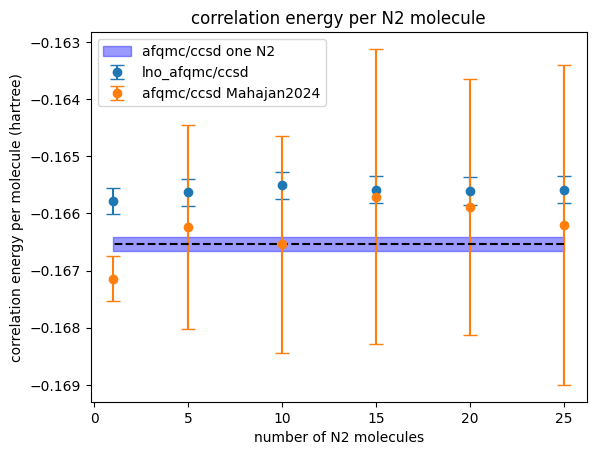

In [25]:
plt.errorbar(n_n2,e_per_mol,yerr=err_per_mol,fmt='o',capsize=5,label='lno_afqmc/ccsd')
plt.errorbar(n_n2,afqmc_corr_per_mol,yerr=afqmc_err_per_mol,fmt='o',capsize=5,label='afqmc/ccsd Mahajan2024')
x = np.linspace(max(n_n2),min(n_n2),100)
plt.plot(x,np.array([afqmc_corr]*100),color='black', linestyle='--')
plt.fill_between(x, np.array([afqmc_corr]*100) + 0.00006*2, np.array([afqmc_corr]*100) - 0.00006*2, color='blue', alpha=0.4,label='afqmc/ccsd one N2')
plt.xlabel('number of N2 molecules')
plt.ylabel('correlation energy per molecule (hartree)')
plt.title('correlation energy per N2 molecule')
plt.legend()
plt.show()

In [ ]:
# no frozen -0.165677 +/- 0.000113
# mp2 -0.165815

In [21]:
# afqmc/ccsd frozen -108.7109 +/- 0.0001
afqmc_corr = -108.7109+108.54436035575
print(afqmc_corr)

-0.166539644249994


In [ ]:
# lno 1e-6 afqmc/ccsd -0.165560 +/- 0.000112